In [40]:
#Imports
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, average_precision_score
import xgboost as xgb
from tqdm import tqdm

#### For some imports you made need to install, simply do pip install 'library' for desired libray

# Predicting The 2024 NFL Champion with Machine Learning
## Steps:
### Feature Selection:
- After reading the completed dataset for ml, we need to analyze all feature of set for multi-collinearity. 
- The goal of this step is to pick the best set of features for model performance, hand-selection was done over feature_selector for time sake.
- Feature don't always select the best features to use for the model analyzing the backtesting AP Champion.
- Removing many mulit-correlated features generally always improves model performance.
- A dummy model was ran to see how the features mesh. 
### Model Selection:
- Complex non-linear models were used for this: (XGboost, RandomForest, NeuralNetwork)
- The models hyper parameters were gridsearched and each model was evaluated by rmse, mse, mae, and average top 4 precision.
- Models runs take about 20-30 minutes to run. This step isn't necessary if you already have a good idea of what model to use
, this step is done if you what to explore different models with the problem.
### Evaluating Model(s) Error:
- For this case random forest and xgboost were better than the neural network in all metrics of the 2023 season.
### Model Chosen for extensive use: (RandomForest)
- Tunned the hyper paramters more, gridsearch, hand-tune, and find the most accurate results possible on the most important error metrics
- Most important error metrics: AP Champion Backtested
### Examine Feature Importance:
- Used both SHAP and regular feature important to analyze the best features and see how each feature contributes toward the prediction.

In [41]:
df = pd.read_excel("NFL Champion RawData.xlsx")
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'team L1Y cs', 'team L3Y cs', 'team L5Y cs', 'team L8Y cs', 'franchise L1Y cs', 'franchise L3Y cs', 'franchise L5Y cs', 'franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_off

In [42]:
#selecting columns that only contain numbers to analyze
data_columns = ['sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'team L1Y cs', 'team L3Y cs', 'team L5Y cs', 'team L8Y cs', 'franchise L1Y cs', 'franchise L3Y cs', 'franchise L5Y cs', 'franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP', 'team_defense_G', 'team_defense_PA', 'team_defense_Tot Yds & TO_Yds', 'team_defense_Tot Yds & TO_Ply', 'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD', 'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 'team_defense_Passing_Int', 'team_defense_Passing_NY/A', 'team_defense_Passing_1stD', 'team_defense_Passing_Att', 'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD', 'team_defense_Penalties_Pen', 'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP', 'passing_offense_G', 'passing_offense_Cmp', 'passing_offense_Att', 'passing_offense_Cmp%', 'passing_offense_Yds', 'passing_offense_TD', 'passing_offense_TD%', 'passing_offense_Int', 'passing_offense_Int%', 'passing_offense_Lng', 'passing_offense_Y/A', 'passing_offense_AY/A', 'passing_offense_Y/C', 'passing_offense_Y/G', 'passing_offense_Rate', 'passing_offense_Sk', 'passing_offense_Yds.1', 'passing_offense_Sk%', 'passing_offense_NY/A', 'passing_offense_ANY/A', 'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP']

df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

In [43]:
# Assuming you have already created the DataFrame 'data' with your selected columns

# Generate a correlation matrix
correlation_matrix = data.corr()

# Set a correlation threshold
correlation_threshold = .90

# Identify and print columns to be removed
columns_to_remove = set()
print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

# Optional: Create a new DataFrame with correlated columns removed
data_filtered = data.drop(columns=columns_to_remove)

Columns to be Removed:
team L5Y cs (correlated with sum playoff games): 0.91
team L8Y cs (correlated with sum playoff games): 0.95
franchise L1Y cs (correlated with team L1Y cs): 0.92
team L5Y cs (correlated with team L3Y cs): 0.96
team L8Y cs (correlated with team L3Y cs): 0.93
L (correlated with W): -1.00
W-L% (correlated with W): 1.00
PD (correlated with W): 0.91
MoV (correlated with W): 0.91
OSRS (correlated with PF): 0.92
team_offense_PF (correlated with PF): 1.00
team_defense_PA (correlated with PA): 1.00
team_defense_G (correlated with team_offense_G): 1.00
passing_offense_G (correlated with team_offense_G): 1.00
team_offense_Tot Yds & TO_Y/P (correlated with team_offense_Tot Yds & TO_Yds): 0.91
team_offense_Tot Yds & TO_1stD (correlated with team_offense_Tot Yds & TO_Yds): 0.92
passing_offense_Cmp (correlated with team_offense_Tot Yds & TO_Cmp): 1.00
passing_offense_Att (correlated with team_offense_Tot Yds & TO_Att): 1.00
team_offense_Passing_1stD (correlated with team_offense

In [45]:
# Print all columns in the new DataFrame 'data_filtered' in the specified format
print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

# Print columns that were removed in the specified format
print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))


Columns in data_filtered:
'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'team L1Y cs', 'team L3Y cs', 'franchise L3Y cs', 'franchise L5Y cs', 'franchise L8Y cs', 'W', 'T', 'PF', 'PA', 'SoS', 'SRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP', 'team_defens

## Feature Selection:
- Identificaiton Columns: 'Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season',
- Prediction Column:  'champion share',  
- Additional Features Removed:, 'make playoffs', 'rk playoffs', 'T', 'team_offense_EXP'
- Feature Change Out: 'W' = 'SRS', 'PF'='DSRS', 'PA'='OSRS'

Removed useless and multi-correlated features beings wins, point differential features, and ties.

### The Importance of SRS Explained:
From looking over the most stats in the correlation matrix there were many point differential stats that correlated with each other highly, so many had to be removed.
Choosing SRS was the best fit for the model. SRS is the most advanced PD stat, because it adjust for strength of schedule and when experimenting with the other PD stats,
SRS out performed them. Something to learn from this is that direct correlation (pearson correlation coefficents) are not always the correct answer.

In [104]:
features = ['sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games',
            'sum champion', 'team L1Y cs', 'team L3Y cs', 'franchise L3Y cs', 'franchise L5Y cs', 'franchise L8Y cs', 
            'SRS', 'OSRS', 'DSRS', 'SoS', '1 seed', '2 seed', '3 seed', 
            '4 seed', '5 seed', '6 seed', 'pso', 'team_offense_G', 'team_offense_Tot Yds & TO_Yds', 
            'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_Cmp', 
            'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A',
            'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 
            'team_offense_Penalties_Pen', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_defense_Tot Yds & TO_Yds',
            'team_defense_Tot Yds & TO_Ply', 'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD',
            'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 'team_defense_Passing_Int', 'team_defense_Passing_Att',
            'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD', 'team_defense_Penalties_Pen', 
            'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP', 'passing_offense_Cmp%',
            'passing_offense_Lng', 'passing_offense_AY/A', 'passing_offense_Y/C', 'passing_offense_Sk', 'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP']

# Count the number of features
num_features = len(features)

# Print the number of features
print(f"Number of features: {num_features}")

Number of features: 73


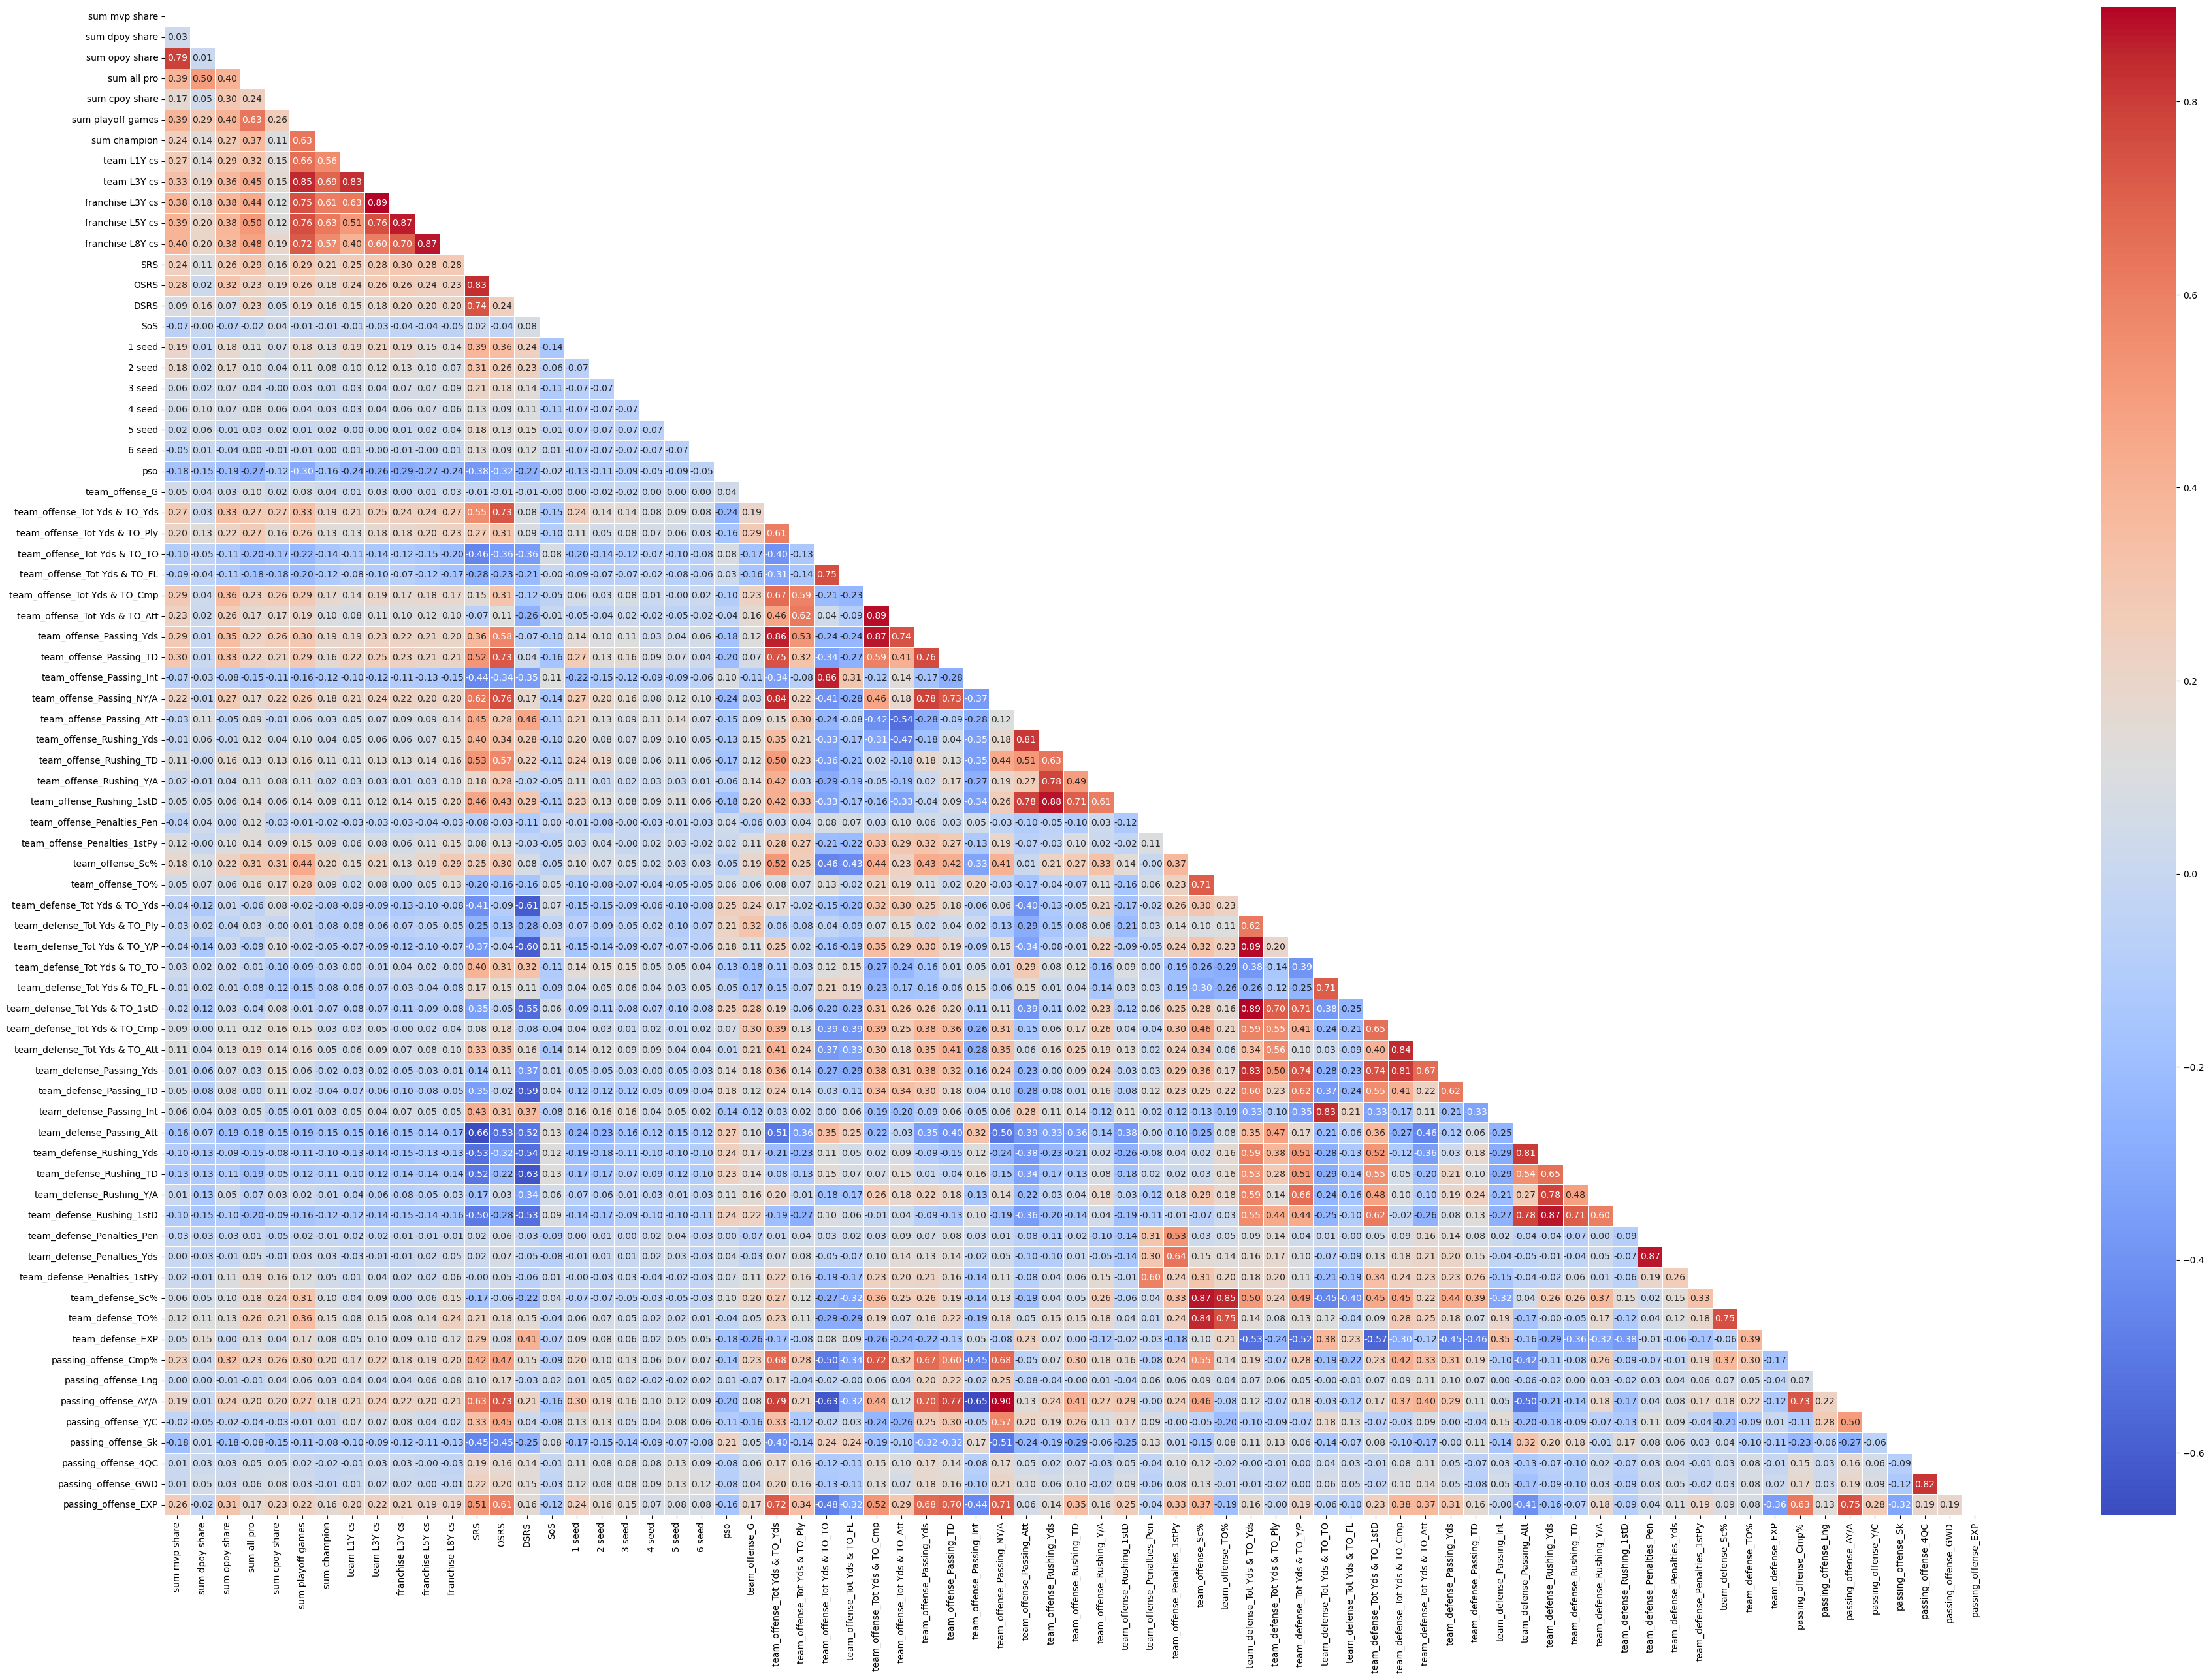

In [105]:
# Extract only the selected features from the DataFrame
selected_features_data = data[features]

# Generate a correlation matrix
correlation_matrix = selected_features_data.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(45, 30))

# Create a heatmap using seaborn with the masked upper triangle
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)

# Show the plot
plt.show()

### Dummy Model To Test how the Features Mesh:
- Random model chosen: RandomForest is a good choice to test.

In [106]:
#dummy model

#training/testing
train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

#scaling
sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

#model parameters
rf = RandomForestRegressor(n_estimators=500, random_state=75, min_samples_split=2, max_depth=5)
rf.fit(train[features], train["champion share"])

#predicting
predictions = rf.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make playoffs"] == 1]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])

#error metrics
mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")


#feature importance
f_list = list(features)
f_importance = pd.Series(rf.feature_importances_, index = f_list).sort_values(ascending = False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")


# Filter to include only playoff teams
frame_playoff = test[test["make playoffs"] == 1]

# Predicting
predictions = rf.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)

# Concatenate predictions to the playoff DataFrame
frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)

# Sort the DataFrame for playoff teams based on predicted champion share
frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])

# Print Full Results for Playoff Teams
print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.to_string())

Error Metrics: 

PT MAE:  0.07214194008034183
PT MSE:  0.01748795135552681
PT RMSE:  0.13224201811650793
-----------------------------------------------------------------------------

Feature Importance: 

SRS                              0.422839
2 seed                           0.132651
1 seed                           0.131415
4 seed                           0.029991
team_offense_Passing_Yds         0.017918
DSRS                             0.013905
3 seed                           0.013008
passing_offense_EXP              0.012642
passing_offense_Lng              0.011132
team_defense_EXP                 0.010453
pso                              0.009343
passing_offense_Y/C              0.007990
team_defense_Rushing_Y/A         0.007794
sum all pro                      0.007639
team_defense_Tot Yds & TO_Yds    0.006292
team L3Y cs                      0.006012
OSRS                             0.005703
team_defense_Tot Yds & TO_Ply    0.005472
team_offense_Sc%                 0.005

In [107]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(4)
print("Ranking Accuracy (Top 4):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(4)

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Top 4: ", ap)

Ranking Accuracy (Top 4):

   Season_x                 Team  champion share_x  predicted champion share_x  Rank  Season_y  champion share_y  predicted champion share_y  Predicted Rank
0      2023   Kansas City Chiefs              1.00                    0.664995     1      2023              1.00                    0.664995               1
1      2023  Philadelphia Eagles              0.75                    0.588213     2      2023              0.75                    0.588213               2
2      2023  San Francisco 49ers              0.50                    0.538425     3      2023              0.50                    0.538425               3
3      2023   Cincinnati Bengals              0.50                    0.167683     4      2023              0.50                    0.167683               8

PT AP Top 4:  0.875


In [60]:
# Define a list to store predictions and APs for each season
all_predictions = []
aps = []

# Backtesting
for season in range(1991, 2024):
    if season >= 2014:  # Skip seasons before 2014
        train = df[df["Season"] < season].copy()
        test = df[df["Season"] == season].copy()

        sc = MinMaxScaler()
        sc.fit(train[features])
        train[features] = sc.transform(train[features])
        test[features] = sc.transform(test[features])

        rf.fit(train[features], train['champion share'])
        predictions = rf.predict(test[features])
        predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
        frame_playoff = pd.concat([test[["Team", "champion share"]], predictions], axis=1)
        all_predictions.append(frame_playoff)
        ap = find_ap(frame_playoff)
        aps.append(ap)
        print(f"AP for Season {season}: {ap}")

# Calculate and display average error metrics and average AP
average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average MAE: {average_mae}")
print(f"Average MSE: {average_mse}")
print(f"Average RMSE: {average_rmse}")
print(f"Average AP: {average_ap}")
print("=============================================================================")

AP for Season 2014: 0.8041666666666667
AP for Season 2015: 0.95
AP for Season 2016: 0.8875
AP for Season 2017: 0.8928571428571428
AP for Season 2018: 0.875
AP for Season 2019: 1.0
AP for Season 2020: 0.5625
AP for Season 2021: 0.8303571428571428
AP for Season 2022: 0.35416666666666663
AP for Season 2023: 0.875

Average Error Metrics Across All Seasons:
Average MAE: 0.08458878245185583
Average MSE: 0.023141587032807377
Average RMSE: 0.14918752103228453
Average AP: 0.8031547619047619


In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, average_precision_score

# Features and target variable
target_variable = 'champion share'

# Training/testing
train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

# Scaling
sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

# Models and their hyperparameter grids
models = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [5, 10, 15, 100],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'random_state': [1, 5, 10, 15]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [5, 10, 15, 100],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1],
            'random_state': [1, 5, 10, 15]
        }
    },
    'NeuralNetwork': {
        'model': MLPRegressor(),
        'params': {
            'hidden_layer_sizes': [(64, 32), (32, 16)],
            'activation': ['relu'],
            'solver': ['adam'],
            'batch_size': [16, 32, 64],
            'learning_rate_init': [0.001, 0.01],
            'random_state': [1, 5, 10, 15]
        }
    }
}

from tqdm import tqdm
# Grid search and evaluation
results = {}
for model_name, model_info in models.items():
    param_grid = ParameterGrid(model_info['params'])
    best_mae = np.inf
    best_params = None  # Added to keep track of best parameters

    for params in tqdm(param_grid, desc=f"Grid search for {model_name}", position=0, leave=True):
        if model_name == 'NeuralNetwork':
            model = MLPRegressor()
            model.set_params(**params)
            model.fit(train[features], train[target_variable])
            predictions = model.predict(test[features])
        else:
            model = model_info['model'].set_params(**params)
            model.fit(train[features], train[target_variable])
            predictions = model.predict(test[features])

        # Calculate MAE
        mae = mean_absolute_error(test[target_variable], predictions)

        if mae < best_mae:
            best_mae = mae
            best_params = params  # Update best_params when a better model is found

    # Train the model with the best parameters
    if model_name == 'NeuralNetwork':
        final_model = MLPRegressor()
        final_model.set_params(**best_params)
        final_model.fit(train[features], train[target_variable])
    else:
        final_model = model_info['model'].set_params(**best_params)
        final_model.fit(train[features], train[target_variable])

    # Add the 'predicted champion share' column to the test DataFrame
    test['predicted champion share'] = final_model.predict(test[features])

    # Calculate average precision metric
    ap = find_ap(test)
    
    # Print metrics for each model
    print("=============================================================================\n")
    print(f"Model: {model_name}")
    print(f"PT AP Top 4: {ap}")
    print(f"MAE: {best_mae}")
    print(f"Best Parameters: {best_params}")
    print("-----------------------------------------------------------------------------\n")

    # Store results
    results[model_name] = {
        'MAE': best_mae,
        'Best_Params': best_params,
        'Average_Precision_Top_4': ap
    }

    # Display completion percentage
    completion_percentage = (len(results) / len(models)) * 100
    print(f"Model {model_name} completed. {completion_percentage:.2f}% done.")

# Display final completion message
print("Grid search and evaluation completed.")

Grid search for RandomForest: 100%|██████████| 192/192 [02:05<00:00,  1.52it/s]



Model: RandomForest
PT AP Top 4: 0.875
MAE: 0.06255917659330339
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 5, 'random_state': 15}
-----------------------------------------------------------------------------

Model RandomForest completed. 33.33% done.


Grid search for XGBoost: 100%|██████████| 128/128 [00:08<00:00, 15.59it/s]



Model: XGBoost
PT AP Top 4: 0.8125
MAE: 0.08486181456100894
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'random_state': 1}
-----------------------------------------------------------------------------

Model XGBoost completed. 66.67% done.


Grid search for NeuralNetwork: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]



Model: NeuralNetwork
PT AP Top 4: 0.95
MAE: 0.07966534049505689
Best Parameters: {'activation': 'relu', 'batch_size': 32, 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.01, 'random_state': 15, 'solver': 'adam'}
-----------------------------------------------------------------------------

Model NeuralNetwork completed. 100.00% done.
Grid search and evaluation completed.


## XGBoost Model:

In [28]:
#training/testing
train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

#scaling
sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

# Model parameters
# XGBoost model
xgb = XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=1)
xgb.fit(train[features], train["champion share"])

#predicting
predictions = xgb.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make playoffs"] == 1]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])

#error metrics
mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")


#feature importance
f_list = list(features)
f_importance = pd.Series(xgb.feature_importances_, index = f_list).sort_values(ascending = False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")


# Filter to include only playoff teams
frame_playoff = test[test["make playoffs"] == 1]

# Predicting
predictions = xgb.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)

# Concatenate predictions to the playoff DataFrame
frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)

# Sort the DataFrame for playoff teams based on predicted champion share
frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])

# Print Full Results for Playoff Teams
print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.to_string())

Error Metrics: 

PT MAE:  0.08486181456100894
PT MSE:  0.025395535255661555
PT RMSE:  0.15935976674073526
-----------------------------------------------------------------------------

Feature Importance: 

1 seed                           0.144241
2 seed                           0.120433
SRS                              0.109495
passing_offense_EXP              0.051133
franchise L3Y cs                 0.044209
team_defense_Sc%                 0.034817
team_offense_Passing_Yds         0.027642
4 seed                           0.022619
team_offense_Penalties_Yds       0.018931
team_defense_Tot Yds & TO_TO     0.018355
3 seed                           0.017269
DSRS                             0.015984
team_defense_Tot Yds & TO_Yds    0.014803
team_defense_Penalties_Yds       0.014736
team_offense_Sc%                 0.014016
team_offense_Tot Yds & TO_Yds    0.012638
passing_offense_ANY/A            0.012517
team_defense_Passing_Yds         0.011779
team_defense_Tot Yds & TO_Att    0.01

### XGBoost Top 4 Teams Evaluation:

In [29]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(4)
print("Ranking Accuracy (Top 4):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(4)

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Top 4: ", ap)

Ranking Accuracy (Top 4):

   Season_x                 Team  champion share_x  predicted champion share_x  Rank  Season_y  champion share_y  predicted champion share_y  Predicted Rank
0      2023   Kansas City Chiefs              1.00                    0.686085     1      2023              1.00                    0.686085               2
1      2023  Philadelphia Eagles              0.75                    0.523706     2      2023              0.75                    0.523706               4
2      2023  San Francisco 49ers              0.50                    0.773775     3      2023              0.50                    0.773775               1
3      2023   Cincinnati Bengals              0.50                    0.180022     4      2023              0.50                    0.180022               8

PT AP Top 4:  0.8125


In [30]:
# Define a list to store predictions and APs for each season
all_predictions = []
aps = []

# Backtesting
for season in range(1991, 2024):
    if season >= 2014:  # Skip seasons before 2014
        train = df[df["Season"] < season].copy()
        test = df[df["Season"] == season].copy()

        sc = MinMaxScaler()
        sc.fit(train[features])
        train[features] = sc.transform(train[features])
        test[features] = sc.transform(test[features])

        xgb.fit(train[features], train['champion share'])
        predictions = xgb.predict(test[features])
        predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
        frame_playoff = pd.concat([test[["Team", "champion share"]], predictions], axis=1)
        all_predictions.append(frame_playoff)
        ap = find_ap(frame_playoff)
        aps.append(ap)
        print(f"AP for Season {season}: {ap}")

# Calculate and display average error metrics and average AP
average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average MAE: {average_mae}")
print(f"Average MSE: {average_mse}")
print(f"Average RMSE: {average_rmse}")
print(f"Average AP: {average_ap}")
print("=============================================================================")

AP for Season 2014: 0.5011904761904762
AP for Season 2015: 1.0
AP for Season 2016: 1.0
AP for Season 2017: 0.85
AP for Season 2018: 0.9166666666666666
AP for Season 2019: 1.0
AP for Season 2020: 0.5700757575757576
AP for Season 2021: 0.6458333333333333
AP for Season 2022: 0.44047619047619047
AP for Season 2023: 0.8125

Average Error Metrics Across All Seasons:
Average MAE: 0.08613504668102223
Average MSE: 0.026502511680326708
Average RMSE: 0.15914413074964173
Average AP: 0.7736742424242424


### XGBoost Champion Evaluation:

In [31]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(1) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

                 Team  champion share_x  predicted champion share_x  Rank  champion share_y  predicted champion share_y  Predicted Rank
0  Kansas City Chiefs               1.0                    0.686085     1               1.0                    0.686085               2

PT AP Champion:  0.5


In [32]:
# Define a list to store predictions and APs for each season
all_predictions = []
aps = []

# Backtesting
for season in range(1991, 2024):
    if season >= 2014:  # Skip seasons before 2014
        train = df[df["Season"] < season].copy()
        test = df[df["Season"] == season].copy()

        sc = MinMaxScaler()
        sc.fit(train[features])
        train[features] = sc.transform(train[features])
        test[features] = sc.transform(test[features])

        xgb.fit(train[features], train['champion share'])
        predictions = xgb.predict(test[features])
        predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
        frame_playoff = pd.concat([test[["Team", "champion share"]], predictions], axis=1)
        all_predictions.append(frame_playoff)
        ap = find_ap(frame_playoff)
        aps.append(ap)
        print(f"Champion AP for Season {season}: {ap}")

# Calculate and display average error metrics and average AP
average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average Champion AP: {average_ap}")
print("=============================================================================")

Champion AP for Season 2014: 0.3333333333333333
Champion AP for Season 2015: 0.25
Champion AP for Season 2016: 1.0
Champion AP for Season 2017: 1.0
Champion AP for Season 2018: 0.3333333333333333
Champion AP for Season 2019: 0.25
Champion AP for Season 2020: 0.3333333333333333
Champion AP for Season 2021: 0.16666666666666666
Champion AP for Season 2022: 0.16666666666666666
Champion AP for Season 2023: 0.5

Average Error Metrics Across All Seasons:
Average Champion AP: 0.43333333333333324


## RandomForest Model:

In [33]:
#training/testing
train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

#scaling
sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

#model parameters
rf = RandomForestRegressor(n_estimators=5, random_state=15, min_samples_split=10, max_depth=10)
rf.fit(train[features], train["champion share"])


#predicting
predictions = rf.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make playoffs"] == 1]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])

#error metrics
mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")


#feature importance
f_list = list(features)
f_importance = pd.Series(rf.feature_importances_, index = f_list).sort_values(ascending = False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")


# Filter to include only playoff teams
frame_playoff = test[test["make playoffs"] == 1]

# Predicting
predictions = rf.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)

# Concatenate predictions to the playoff DataFrame
frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)

# Sort the DataFrame for playoff teams based on predicted champion share
frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])

# Print Full Results for Playoff Teams
print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.to_string())

Error Metrics: 

PT MAE:  0.0625591765933034
PT MSE:  0.01351348733001834
PT RMSE:  0.11624752612429368
-----------------------------------------------------------------------------

Feature Importance: 

SRS                           0.400724
2 seed                        0.115118
1 seed                        0.087727
passing_offense_EXP           0.033083
4 seed                        0.018550
team_defense_EXP              0.017727
passing_offense_Y/C           0.015543
passing_offense_Lng           0.014944
passing_offense_Y/A           0.014609
team_defense_Rushing_Y/A      0.014128
team_defense_Passing_Yds      0.012227
DSRS                          0.011571
team_defense_Passing_NY/A     0.011214
3 seed                        0.010571
team L3Y cs                   0.010235
OSRS                          0.009007
passing_offense_Rate          0.008768
team_defense_Penalties_Pen    0.008546
team_offense_Sc%              0.008314
team_offense_Penalties_Yds    0.008304
dtype: float64


### RandomForest Top 4 Teams Evaluation:

In [34]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(4)
print("Ranking Accuracy (Top 4):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(4)

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Top 4: ", ap)

Ranking Accuracy (Top 4):

   Season_x                 Team  champion share_x  predicted champion share_x  Rank  Season_y  champion share_y  predicted champion share_y  Predicted Rank
0      2023   Kansas City Chiefs              1.00                    0.779002     1      2023              1.00                    0.779002               1
1      2023  Philadelphia Eagles              0.75                    0.553205     2      2023              0.75                    0.553205               2
2      2023  San Francisco 49ers              0.50                    0.486364     3      2023              0.50                    0.486364               3
3      2023   Cincinnati Bengals              0.50                    0.143315     4      2023              0.50                    0.143315               8

PT AP Top 4:  0.875


In [35]:
# Define a list to store predictions and APs for each season
all_predictions = []
aps = []

# Backtesting
for season in range(1991, 2024):
    if season >= 2014:  # Skip seasons before 2014
        train = df[df["Season"] < season].copy()
        test = df[df["Season"] == season].copy()

        sc = MinMaxScaler()
        sc.fit(train[features])
        train[features] = sc.transform(train[features])
        test[features] = sc.transform(test[features])

        rf.fit(train[features], train['champion share'])
        predictions = rf.predict(test[features])
        predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
        frame_playoff = pd.concat([test[["Team", "champion share"]], predictions], axis=1)
        all_predictions.append(frame_playoff)
        ap = find_ap(frame_playoff)
        aps.append(ap)
        print(f"AP for Season {season}: {ap}")

# Calculate and display average error metrics and average AP
average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average MAE: {average_mae}")
print(f"Average MSE: {average_mse}")
print(f"Average RMSE: {average_rmse}")
print(f"Average AP: {average_ap}")
print("=============================================================================")

AP for Season 2014: 0.44047619047619047
AP for Season 2015: 0.6458333333333333
AP for Season 2016: 0.8125
AP for Season 2017: 0.7928571428571429
AP for Season 2018: 0.7291666666666666
AP for Season 2019: 1.0
AP for Season 2020: 0.7644230769230769
AP for Season 2021: 0.5
AP for Season 2022: 0.3604166666666666
AP for Season 2023: 0.875

Average Error Metrics Across All Seasons:
Average MAE: 0.0844086386727596
Average MSE: 0.028751339025416794
Average RMSE: 0.16630344551678797
Average AP: 0.6920673076923076


### RandomForest Champion Evaluation:

In [36]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(1) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

                 Team  champion share_x  predicted champion share_x  Rank  champion share_y  predicted champion share_y  Predicted Rank
0  Kansas City Chiefs               1.0                    0.779002     1               1.0                    0.779002               1

PT AP Champion:  1.0


In [37]:
# Define a list to store predictions and APs for each season
all_predictions = []
aps = []

# Backtesting
for season in range(1991, 2024):
    if season >= 2014:  # Skip seasons before 2014
        train = df[df["Season"] < season].copy()
        test = df[df["Season"] == season].copy()

        sc = MinMaxScaler()
        sc.fit(train[features])
        train[features] = sc.transform(train[features])
        test[features] = sc.transform(test[features])

        rf.fit(train[features], train['champion share'])
        predictions = rf.predict(test[features])
        predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
        frame_playoff = pd.concat([test[["Team", "champion share"]], predictions], axis=1)
        all_predictions.append(frame_playoff)
        ap = find_ap(frame_playoff)
        aps.append(ap)
        
        # Print the reciprocal of each individual AP rounded to 2 decimal places
        reciprocal_ap = 1 / ap
        print(f"Champion AP for Season {season}: {round(ap, 2)} | Predicted Champion Rank: {round(reciprocal_ap, 2)}")

        aps.append(ap)

# Calculate and display average error metrics and average AP
average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

# Calculate the reciprocal of the average AP
reciprocal_average_ap = 1.0 / average_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average Champion AP: {average_ap}")
print("=============================================================================")

Champion AP for Season 2014: 0.125
Champion AP for Season 2015: 0.25
Champion AP for Season 2016: 0.25
Champion AP for Season 2017: 1.0
Champion AP for Season 2018: 0.25
Champion AP for Season 2019: 0.25
Champion AP for Season 2020: 0.5
Champion AP for Season 2021: 0.1
Champion AP for Season 2022: 0.3333333333333333
Champion AP for Season 2023: 1.0

Average Error Metrics Across All Seasons:
Average Champion AP: 0.4058333333333334


## Results: XGBoost v. RandomForest

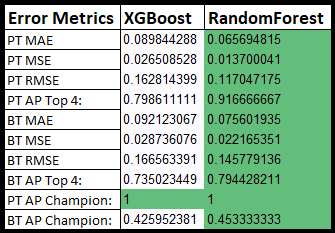

- The RandomForest was the slightly better suited model. Specifically it's BT AP Champion was greater
which is the most important error metric for this problem. "How well does the model predict past champions!"

## The Main Model and Results:

In [108]:
#training/testing
train = df[df["Season"] <= 2022].copy()
test = df[df["Season"] > 2022].copy()

#scaling
sc = MinMaxScaler()
sc.fit(train[features])
train[features]=sc.transform(train[features])
test[features]=sc.transform(test[features])

#model parameters
rf = RandomForestRegressor(n_estimators=500, random_state=75, min_samples_split=2, max_depth=5)
rf.fit(train[features], train["champion share"])

#predicting
predictions = rf.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
frame = df[df["make playoffs"] == 1]
frame = pd.concat([test[["Season", "Team", "champion share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])

#error metrics
mae1 = mean_absolute_error(frame["champion share"], frame["predicted champion share"])
mse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"])
rmse1 = mean_squared_error(frame["champion share"], frame["predicted champion share"], squared=False)


print("Error Metrics: ")
print("=============================================================================\n")
print("PT MAE: ", mae1)
print("PT MSE: ", mse1)
print("PT RMSE: ", rmse1)
print("-----------------------------------------------------------------------------\n")


#feature importance
f_list = list(features)
f_importance = pd.Series(rf.feature_importances_, index = f_list).sort_values(ascending = False)
print("Feature Importance: ")
print("=============================================================================\n")
print(f_importance.head(20))
print("-----------------------------------------------------------------------------\n")


# Filter to include only playoff teams
frame_playoff = test[test["make playoffs"] == 1]

# Predicting
predictions = rf.predict(frame_playoff[features])
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=frame_playoff.index)

# Concatenate predictions to the playoff DataFrame
frame_playoff = pd.concat([frame_playoff[["Season", "Team", "champion share"]], predictions], axis=1)

# Sort the DataFrame for playoff teams based on predicted champion share
frame_playoff.sort_values(["Season", "predicted champion share"], inplace=True, ascending=[False, False])

# Print Full Results for Playoff Teams
print("Full Results (Playoff Teams Only):")
print("=============================================================================\n")
print(frame_playoff.to_string())

Error Metrics: 

PT MAE:  0.07214194008034183
PT MSE:  0.01748795135552681
PT RMSE:  0.13224201811650793
-----------------------------------------------------------------------------

Feature Importance: 

SRS                              0.422839
2 seed                           0.132651
1 seed                           0.131415
4 seed                           0.029991
team_offense_Passing_Yds         0.017918
DSRS                             0.013905
3 seed                           0.013008
passing_offense_EXP              0.012642
passing_offense_Lng              0.011132
team_defense_EXP                 0.010453
pso                              0.009343
passing_offense_Y/C              0.007990
team_defense_Rushing_Y/A         0.007794
sum all pro                      0.007639
team_defense_Tot Yds & TO_Yds    0.006292
team L3Y cs                      0.006012
OSRS                             0.005703
team_defense_Tot Yds & TO_Ply    0.005472
team_offense_Sc%                 0.005

In [109]:
actual = frame_playoff.sort_values("champion share", ascending=False)
predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame_playoff):
    actual = frame_playoff.sort_values("champion share", ascending=False).head(1) #HEAD

    predicted = frame_playoff.sort_values("predicted champion share", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame_playoff)
print("=============================================================================\n")
print("PT AP Champion: ", ap)

Ranking Accuracy (Champion):

   Season_x                Team  champion share_x  predicted champion share_x  Rank  Season_y  champion share_y  predicted champion share_y  Predicted Rank
0      2023  Kansas City Chiefs               1.0                    0.664995     1      2023               1.0                    0.664995               1

PT AP Champion:  1.0


In [110]:
# Define a list to store predictions and APs for each season
all_predictions = []
aps = []

# Backtesting
for season in range(1991, 2024):
    if season >= 2014:  # Skip seasons before 2014
        train = df[df["Season"] < season].copy()
        test = df[df["Season"] == season].copy()

        sc = MinMaxScaler()
        sc.fit(train[features])
        train[features] = sc.transform(train[features])
        test[features] = sc.transform(test[features])

        rf.fit(train[features], train['champion share'])
        predictions = rf.predict(test[features])
        predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)
        frame_playoff = pd.concat([test[["Team", "champion share"]], predictions], axis=1)
        all_predictions.append(frame_playoff)
        ap = find_ap(frame_playoff)
        aps.append(ap)
        
        # Print the reciprocal of each individual AP rounded to 2 decimal places
        reciprocal_ap = 1 / ap
        print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)}")

        aps.append(ap)

# Calculate and display average error metrics and average AP
average_mae = np.mean([mean_absolute_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_mse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"]) for fp in all_predictions])
average_rmse = np.mean([mean_squared_error(fp["champion share"], fp["predicted champion share"], squared=False) for fp in all_predictions])
average_ap = np.mean(aps)

# Calculate min, max, and 95% CI for the AP of the last 10 seasons
last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

# Calculate the reciprocal of the average AP
reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"BT Average Champion AP: {round(average_ap, 2)} | Reciprocal: {round(reciprocal_average_ap, 2)}")
print(f"BT Max Champion AP: {round(min_ap, 2)} | Reciprocal: {round(reciprocal_min_ap, 2)}")
print(f"BT Min Champion AP: {round(max_ap, 2)} | Reciprocal: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

Champion AP for Season 2014: 1.0 | Reciprocal: 1.0
Champion AP for Season 2015: 0.5 | Reciprocal: 2.0
Champion AP for Season 2016: 1.0 | Reciprocal: 1.0
Champion AP for Season 2017: 1.0 | Reciprocal: 1.0
Champion AP for Season 2018: 0.33 | Reciprocal: 3.0
Champion AP for Season 2019: 0.33 | Reciprocal: 3.0
Champion AP for Season 2020: 0.25 | Reciprocal: 4.0
Champion AP for Season 2021: 0.14 | Reciprocal: 7.0
Champion AP for Season 2022: 0.12 | Reciprocal: 8.0
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0

Average Error Metrics Across All Seasons:
BT Average Champion AP: 0.57 | Reciprocal: 1.76
BT Max Champion AP: 0.12 | Reciprocal: 8.0
BT Min Champion AP: 1.0 | Reciprocal: 1.0


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(-225.56944444444443, 0.5, 'Feature')

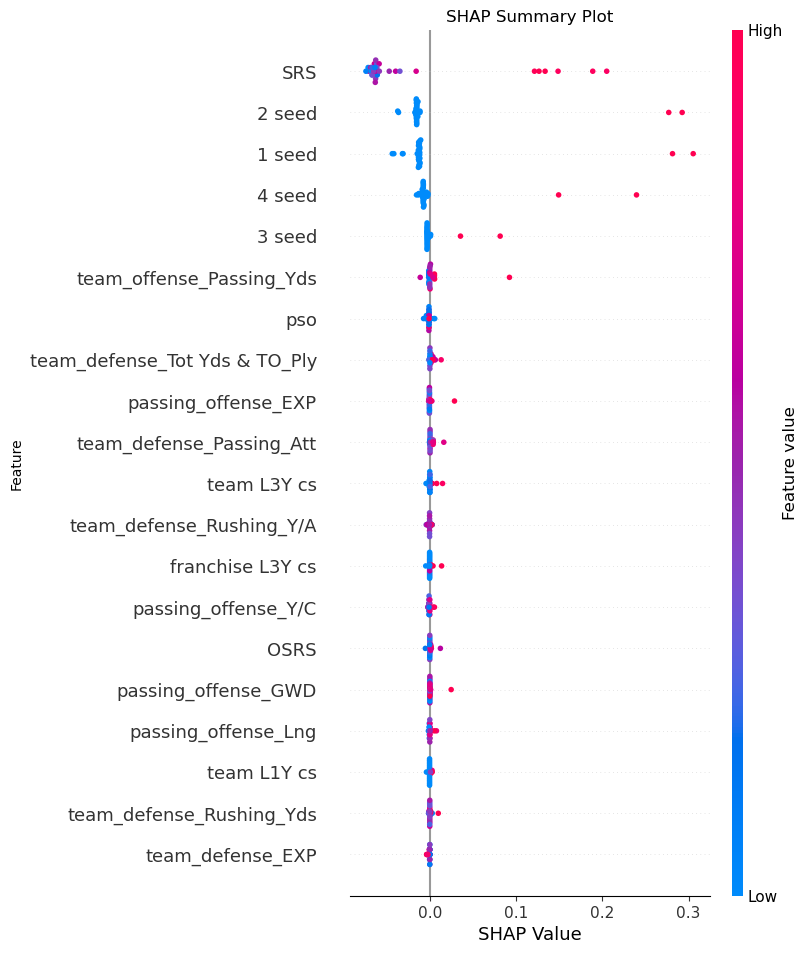

In [111]:
#explaining the features importance with shap for visualization, and different perspective.
import matplotlib.pyplot as plt
import shap

# Explain the Model Predictions using SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test[features])

# Summary Plot of Feature Importance
shap.summary_plot(shap_values, test[features], feature_names=features, show=False)

# Add border, title, x-axis label, and y-axis label
plt.gca().set_title("SHAP Summary Plot")
plt.gca().set_xlabel("SHAP Value")
plt.gca().set_ylabel("Feature")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


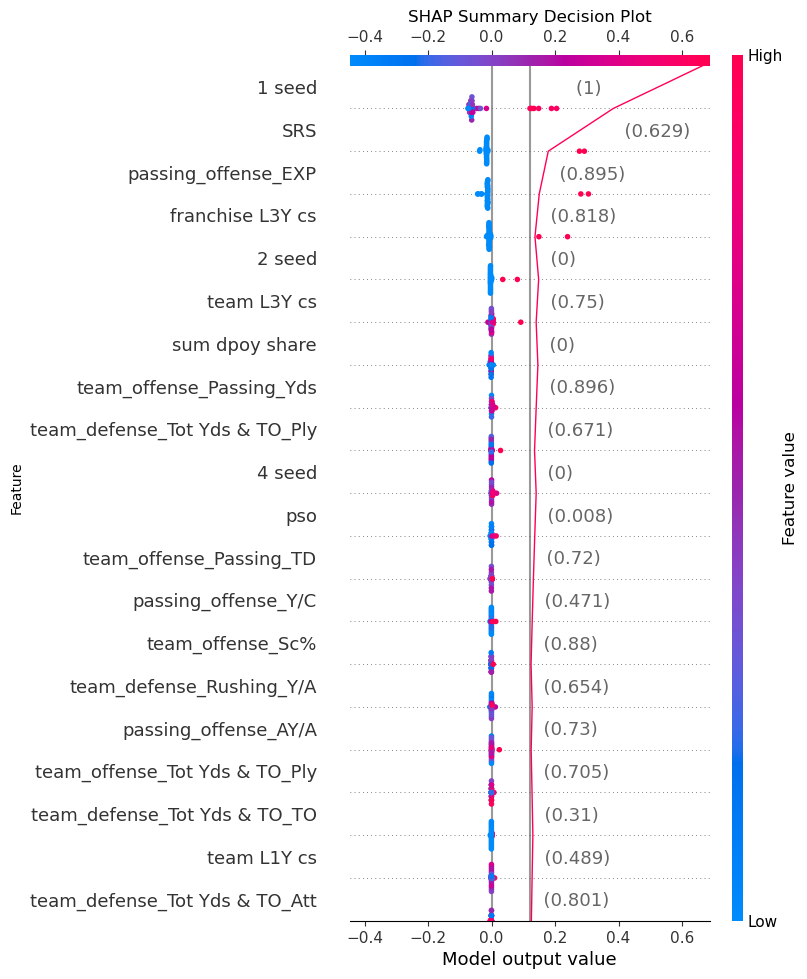

In [112]:
import matplotlib.pyplot as plt
import shap

# ... (previous code)

# Explain the Model Predictions using SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test[features])

# Summary Plot of Feature Importance
shap.summary_plot(shap_values, test[features], feature_names=features, show=False)

# Add border, title, x-axis label, and y-axis label
plt.gca().set_title("SHAP Summary Decision Plot")
plt.gca().set_xlabel("SHAP Value")
plt.gca().set_ylabel("Feature")

# Display SHAP Decision Plot for a Single Prediction
# Replace `row_index` with the index of the specific row you want to visualize
row_index = 0  # Example: visualize the first row
shap.decision_plot(explainer.expected_value, shap_values[row_index], test[features].iloc[row_index], feature_names=features)

# Show the plots
plt.show()


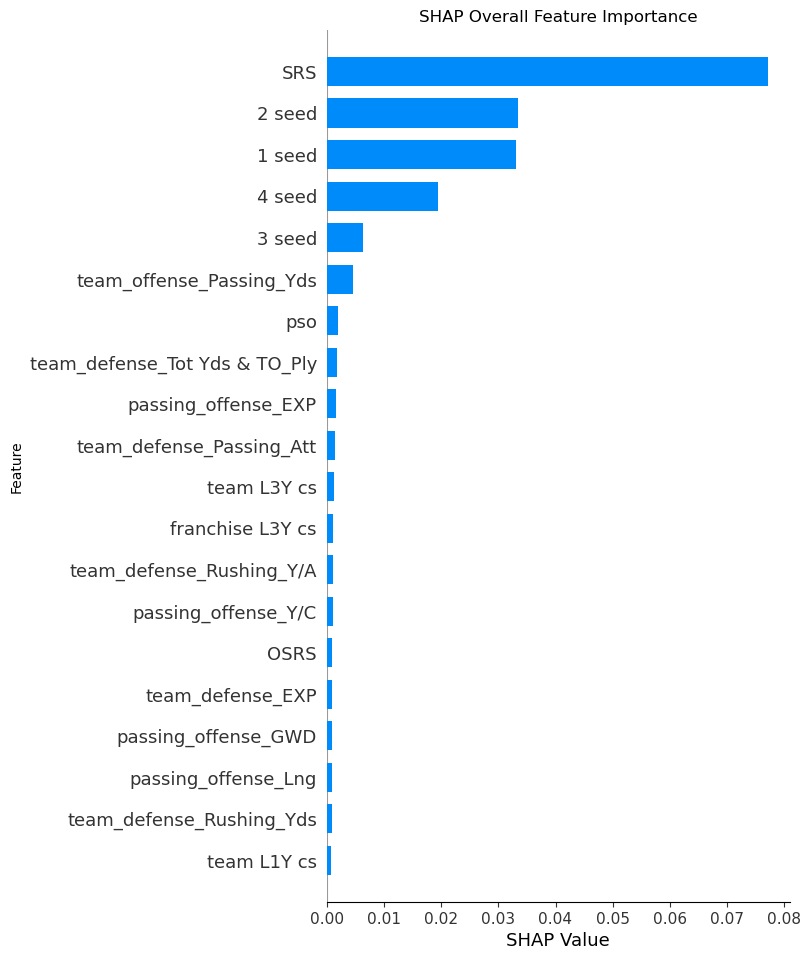

In [94]:
# Explain the Model Predictions using SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test[features])

# Bar Chart of Feature Importance
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values, test[features], feature_names=features, plot_type='bar', show=False)
plt.title("SHAP Overall Feature Importance")
plt.xlabel("SHAP Value")
plt.ylabel("Feature")
plt.show()

In [ ]:
#Export Prediction 
predictions = rf.predict(test[features]) 
predictions = pd.DataFrame(predictions, columns=["predicted champion share"], index=test.index)

frame = pd.concat([test[['Season', 'Team', "Team/Season"]], predictions], axis=1)
frame.sort_values(["Season", "predicted champion share"], inplace=True, ascending = [False, False])
frame.to_excel('NFL Champion Predict.xlsx')